This notebook applies optimization techniques to improve the **handwritten digit classification** analysis using:

- Cross validation and test data
- Evaluating bias and variance
- Test different possible models (changing polynomial degree or regularization parameter)
- Plotting learning curves

#### Digit recognition

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import L2
import sqlite3
import seaborn as sb

In [2]:
connection = sqlite3.connect('data/Optimization.db')
cursor = connection.cursor()

In [82]:
cursor.execute("""CREATE TABLE Cost(J_train REAL,
                                    J_cv REAL,
                                    n_layers REAL,
                                    n_units REAL,
                                    reg REAL
)
""")

In [4]:
(X,y),(X_,y_)  = tf.keras.datasets.mnist.load_data('mnist.npz')
X = np.concatenate((X,X_))
y = np.concatenate((y,y_))

X, X_, y, y_ = train_test_split(X, y, test_size=0.2, random_state=62)
X_test, X_cv, y_test, y_cv = train_test_split(X_, y_, test_size=0.5, random_state=62)

In [4]:
print(X.shape, X_test.shape, X_cv.shape)

(56000, 28, 28) (7000, 28, 28) (7000, 28, 28)


In [5]:
X = X.reshape(-1,X[0].shape[0]*X[0].shape[1])
X_cv = X_cv.reshape(-1,X_cv[0].shape[0]*X_cv[0].shape[1])
X_test = X_test.reshape(-1,X_test[0].shape[0]*X_test[0].shape[1])

In [6]:
print(X.shape, X_test.shape, X_cv.shape)

(56000, 784) (7000, 784) (7000, 784)


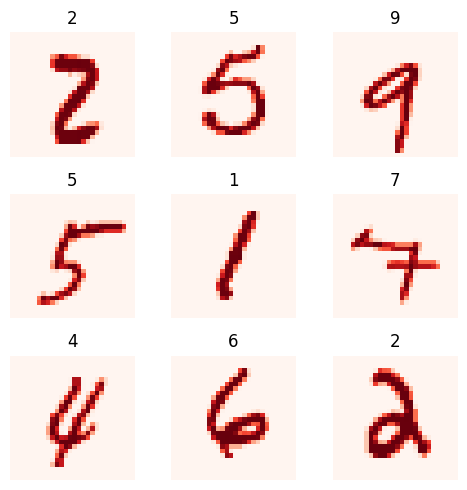

In [17]:
fig,ax = plt.subplots(3,3,figsize=(5,5))

m,n = X.shape

k = 0
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        k = np.random.randint(m)
        ax[i,j].set_axis_off()
        x = int(np.sqrt(X[k].shape[0]))
        ax[i,j].imshow(X[k].reshape((x,x)), cmap='Reds')
        ax[i,j].set_title(y[k])
        k += 1

plt.tight_layout()
plt.show()

Make a prediction:

Model: "Multi_Class_Classification_2_layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 35)                27475     
                                                                 
 dense_30 (Dense)            (None, 622)               22392     
                                                                 
Total params: 49,867
Trainable params: 49,867
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1575/1575 [==============================] - 6s 4ms/step - loss: 9.7314 - val_loss: 2.9977
Epoch 2/10
1575/1575 [==============================] - 7s 4ms/step - loss: 1.6861 - val_loss: 0.8808
Epoch 3/10
1575/1575 [==============================] - 8s 5ms/step - loss: 0.5752 - val_loss: 0.4299
Epoch 4/10
1575/1575 [==============================] - 8s 5ms/step - loss: 0.3514 - val_loss: 0.3302
Epoch 5/10
1575

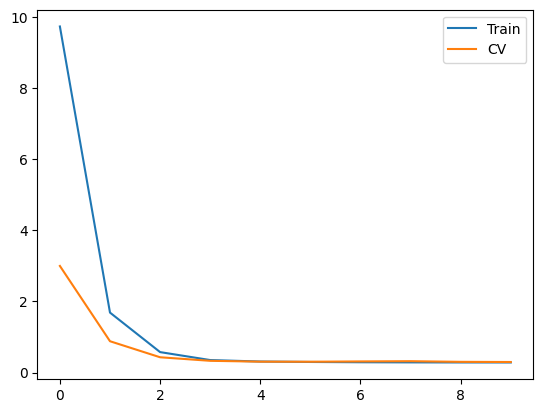

In [17]:
shape_init = tf.keras.Input(shape=(len(X[0]),))
layers_list = []
reg_value = 0.2
n_layers = 2
units_list = []
m,n = X.shape

for i in range(n_layers):
    if i == n_layers-1:
        act = 'linear'
    else:
        act = 'relu'

    Ns = m
    No = 10
    if i == 0:
        Ni = n
    else:
        Ni = units_list[i-1]
    units = int(Ns/(2*(Ni+No)))
    units_list.append(units)
    # units = n_layers * 10 - i*10
    layers_list.append(Dense(units=units, activation=act, kernel_regularizer=L2(reg_value)))

model = Sequential([shape_init] + layers_list,
                name='Multi_Class_Classification_%i_layers'%n_layers
                )
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=Adam(0.0002))
model.summary()
history = model.fit(X, y, validation_split=0.1, epochs=10)
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train','CV'])
plt.show()

The CV vs epochs above, does not correspond to CV in in this notebook, but an automatically chosen CV by tensorflow.

In [18]:
prediction = model.predict(X)
prediction_cv = model.predict(X_cv)
k = 0
j = 0

for i in range(len(prediction)):
    ip = np.where(prediction[i] == max(prediction[i]))
    if ip[0][0] == y[i]:
        k += 1
J_train = 1-k/len(X)

for i in range(len(prediction_cv)):
    ip = np.where(prediction_cv[i] == max(prediction_cv[i]))
    if ip[0][0] == y_cv[i]:
        j += 1
J_cv = 1-j/len(X_cv)

print('J_train =', J_train)
print('J_cv =', J_cv)

219/219 [==============================] - 0s 2ms/step
J_train = 0.04233928571428569
J_cv = 0.047285714285714264


It results in a $\sim 4.7$% and $\sim 4.2$% of misclassification in train and cross-validation data respectively.

Let us try to adjust the model to be more efficient:

In [20]:
def create_model(X_, y_, n_layers, reg_value):
    shape_init = tf.keras.Input(shape=(len(X[0]),))
    layers_list = []

    # checkpoint_path = "models/mnist/cp-{epoch:04d}.ckpt"
    # cp_callback = tf.keras.callbacks.ModelCheckpoint(
    # filepath=checkpoint_path, 
    # verbose=1, 
    # save_weights_only=True,
    # save_freq=5*batch_size)

    for i in range(n_layers):
        if i == n_layers-1:
            act = 'linear'
        else:
            act = 'relu'
        
        #Automatically define number of units for each layer
        Ns = m
        No = 10
        if i == 0:
            Ni = n
        else:
            Ni = units_list[i-1]
        units = int(Ns/(2*(Ni+No)))
        units_list.append(units)

        # units = n_layers * 10 - i*10
        layers_list.append(Dense(units=units, activation=act, kernel_regularizer=L2(reg_value)))

    model = Sequential([shape_init] + layers_list,
                    name='Multi_Class_Classification_%i_layers'%n_layers
                    )
    model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=Adam(0.0002))
    model.fit(X_, y_, epochs=10)

    # model.save('models/multi_class_classification_mnist_cv_%s_layers'%n_layers)
    
    return model

In [21]:
def misclassification(X_, y_, prediction):
    j = 0
    m,n = X_.shape
    for i in range(m):
        ip = np.where(prediction[i] == max(prediction[i]))
        if ip[0][0] != y_[i]:
            j += 1
    J = j/m
    return J

def cost_final(X_, y_, X_cv_, y_cv_, n_layers, reg_value):
    model = create_model(X_, y_, n_layers, reg_value)
    prediction = model.predict(X_)
    prediction_cv = model.predict(X_cv)

    J_train = misclassification(X_, y_, prediction)
    J_cv = misclassification(X_cv_, y_cv_, prediction_cv)
    
    return J_train, J_cv, model

In [22]:
def evaluate_layers_units():
    n_layers_list = list(range(1,7))
    J_train_array = np.zeros(len(n_layers_list))
    J_cv_array = np.zeros(len(n_layers_list))
    reg_value = 0.2

    for i in range(len(n_layers_list)):
        n_layers = n_layers_list[i]
        n_ = list(reversed(range(1, n_layers)))
        n_units = sum([10*j for j in n_])
        J_train, J_cv, model = cost_final(X, y, X_cv, y_cv, n_layers, reg_value)

        J_train_array[i] = J_train
        J_cv_array[i] = J_cv

        cursor.execute("INSERT INTO Cost VALUES (?,?,?,?,?)",(J_train, J_cv, n_layers, n_units, reg_value,))
    connection.commit()
        
    return J_train_array, J_cv_array, n_layers_list

In [23]:
def evaluate_regularization(n_layers):
    reg_list = np.geomspace(0.01,1,7)
    J_train_array = np.zeros(len(reg_list))
    J_cv_array = np.zeros(len(reg_list))
    # n_layers = 5
    n_ = list(reversed(range(1, n_layers)))
    n_units = sum([10*j for j in n_])

    for i in range(len(reg_list)):
        reg_value = reg_list[i]
        J_train, J_cv, model = cost_final(X, y, X_cv, y_cv, n_layers, reg_value)

        J_train_array[i] = J_train
        J_cv_array[i] = J_cv

        print('regularization =', reg_value)

        cursor.execute("INSERT INTO Cost VALUES (?,?,?,?,?)",(J_train, J_cv, n_layers, n_units, reg_value,))
    connection.commit()
        
    return J_train_array, J_cv_array, reg_list

In [25]:
J_train_, J_cv_, n_layers_list = evaluate_layers_units()

Epoch 1/10
1750/1750 [==============================] - 4s 2ms/step - loss: 25.0283
Epoch 2/10
1750/1750 [==============================] - 3s 2ms/step - loss: 8.1822
Epoch 3/10
1750/1750 [==============================] - 3s 2ms/step - loss: 5.4158
Epoch 4/10
1750/1750 [==============================] - 3s 2ms/step - loss: 4.1568
Epoch 5/10
1750/1750 [==============================] - 3s 2ms/step - loss: 3.3952
Epoch 6/10
1750/1750 [==============================] - 3s 2ms/step - loss: 2.8973
Epoch 7/10
1750/1750 [==============================] - 3s 2ms/step - loss: 2.5167
Epoch 8/10
1750/1750 [==============================] - 4s 2ms/step - loss: 2.1646
Epoch 9/10
1750/1750 [==============================] - 4s 2ms/step - loss: 1.9205
Epoch 10/10
219/219 [==============================] - 0s 1ms/step
Epoch 1/10
1750/1750 [==============================] - 6s 3ms/step - loss: 8.2446
Epoch 2/10
1750/1750 [==============================] - 7s 4ms/step - loss: 1.1918
Epoch 3/10
1750/175

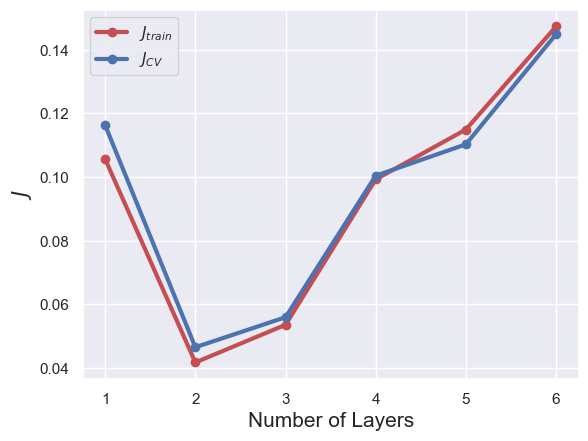

In [26]:
plt.figure(dpi=100)
sb.set()
plt.plot(n_layers_list, J_train_, 'ro-', lw=3, label=r'$J_{train}$')
plt.plot(n_layers_list, J_cv_, 'bo-', lw=3, label=r'$J_{CV}$')
plt.xlabel(r'Number of Layers', fontsize=15)
plt.ylabel(r'$J$', fontsize=15)
plt.legend()
plt.show()

In [27]:
J_train_, J_cv_, reg_list = evaluate_regularization(n_layers=2)

Epoch 1/10
1750/1750 [==============================] - 7s 4ms/step - loss: 3.3737
Epoch 2/10
1750/1750 [==============================] - 7s 4ms/step - loss: 0.8314
Epoch 3/10
1750/1750 [==============================] - 7s 4ms/step - loss: 0.5738
Epoch 4/10
1750/1750 [==============================] - 5s 3ms/step - loss: 0.4177
Epoch 5/10
1750/1750 [==============================] - 5s 3ms/step - loss: 0.3177
Epoch 6/10
1750/1750 [==============================] - 5s 3ms/step - loss: 0.2566
Epoch 7/10
1750/1750 [==============================] - 5s 3ms/step - loss: 0.2175
Epoch 8/10
1750/1750 [==============================] - 5s 3ms/step - loss: 0.1874
Epoch 9/10
1750/1750 [==============================] - 5s 3ms/step - loss: 0.1699
Epoch 10/10
219/219 [==============================] - 0s 2ms/step
regularization = 0.01
Epoch 1/10
1750/1750 [==============================] - 6s 3ms/step - loss: 3.5547
Epoch 2/10
1750/1750 [==============================] - 5s 3ms/step - loss: 1.081

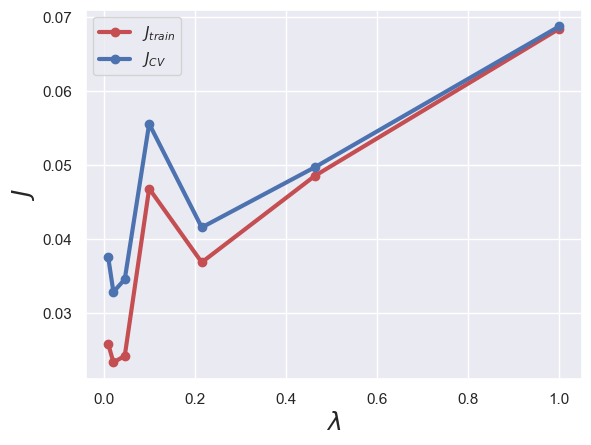

In [31]:
plt.figure(dpi=100)
sb.set()
plt.plot(reg_list, J_train_, 'ro-', lw=3, label=r'$J_{train}$')
plt.plot(reg_list, J_cv_, 'bo-', lw=3, label=r'$J_{CV}$')
plt.xlabel(r'$\lambda$', fontsize=18)
plt.ylabel(r'$J$', fontsize=18)
plt.legend()
plt.show()

Let us make a model with parameters found, but for a higher number of epochs:

Model: "Multi_Class_Classification_2_layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 35)                27475     
                                                                 
 dense_71 (Dense)            (None, 35)                1260      
                                                                 
Total params: 28,735
Trainable params: 28,735
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1750/1750 [==============================] - 5s 3ms/step - loss: 6.8170
Epoch 2/15
1750/1750 [==============================] - 4s 2ms/step - loss: 2.3205
Epoch 3/15
1750/1750 [==============================] - 4s 2ms/step - loss: 1.6194
Epoch 4/15
1750/1750 [==============================] - 4s 2ms/step - loss: 1.1092
Epoch 5/15
1750/1750 [==============================] - 4s 2ms/step - loss: 0.6785
Epoch 6/

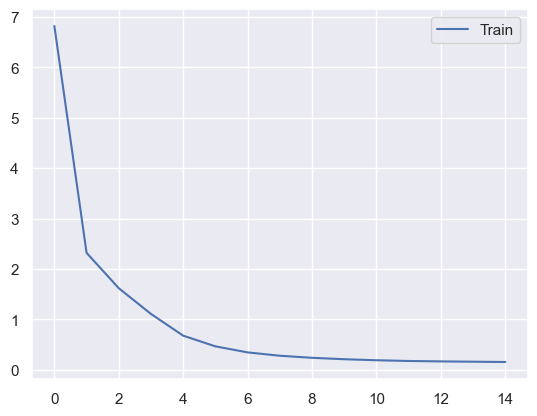

In [35]:
shape_init = tf.keras.Input(shape=(len(X[0]),))
layers_list = []
reg_value = 0.02
n_layers = 2

for i in range(n_layers):
    if i == n_layers-1:
        act = 'linear'
    else:
        act = 'relu'
    
    #Automatically define number of units for each layer
        Ns = m
        No = 10
        if i == 0:
            Ni = n
        else:
            Ni = units_list[i-1]
        units = int(Ns/(2*(Ni+No)))
        units_list.append(units)

    # units = n_layers * 10 - i*10
    layers_list.append(Dense(units=units, activation=act, kernel_regularizer=L2(reg_value)))

model = Sequential([shape_init] + layers_list,
                name='Multi_Class_Classification_%i_layers'%n_layers
                )
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=Adam(0.0002))
model.summary()
history = model.fit(X, y, epochs=15)

plt.plot(history.history['loss'])
plt.legend(['Train'])
plt.show()

The learning curve above corresponds to internal measure of epochs vs loss in tensorflow.

In [39]:
prediction = model.predict(X)
prediction_cv = model.predict(X_cv)
prediction_test = model.predict(X_test)

J_train = misclassification(X, y, prediction)
J_cv = misclassification(X_cv, y_cv, prediction_cv)
J_test = misclassification(X_test, y_test, prediction_test)

print('The misclassification in the train, cross validation and test set respectively were:\n J_train: %.2f%%\n J_cv: %.2f%%\n J_test: %.2f%%'%(100*J_train, 100*J_cv, 100*J_test))

219/219 [==============================] - 1s 2ms/step
The misclassification in the train, cross validation and test set respectively were:
 J_train: 2.17%
 J_cv: 3.23%
 J_test: 3.43%


The choices were able to improve the model prediction from $\sim 4.2$% to $\sim 3.2$% (reaching $96.8$% of accuracy) in the cross validation dataset, which is an acceptable performance for a very simple test of NN like the ones tested here.

Let us save this model to be tested in future:

In [40]:
model.save('models/mnist/multi_digit_classification_mnist_cv_%s_layers'%2)

INFO:tensorflow:Assets written to: models/mnist/multi_digit_classification_mnist_cv_2_layers\assets


Let us load the binary classification model (that predicts 0 or 1) to calculate *precision*, *recall* and *F1* metric:

In [24]:
loaded_model = tf.keras.models.load_model('models/mnist/binary_digit_classification_mnist')

In [25]:
(X,y),(X_test,y_test)  = tf.keras.datasets.mnist.load_data('mnist.npz')

X = X.reshape(-1,X[0].shape[0]*X[0].shape[1])
X_test = X_test.reshape(-1,X_test[0].shape[0]*X_test[0].shape[1])

iy = np.where((y == 0) | (y == 1))
y = y[iy]
X = X[iy]

iyt = np.where((y_test == 0) | (y_test == 1))
y_test = y_test[iyt]
X_test = X_test[iyt]

$$\text{Precision} = \frac{\text{true positives}}{\text{predicted positives}} = \frac{\text{true positives}}{\text{true positives} + \text{false positives}}$$

$$\text{Recall} = \frac{\text{true positives}}{\text{actual positives}} = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

In [31]:
prediction = loaded_model.predict(X_test)
print(prediction)

67/67 [==============================] - 0s 2ms/step
[[9.9992210e-01]
 [3.0745773e-04]
 [9.9993169e-01]
 ...
 [9.9993169e-01]
 [3.0745773e-04]
 [9.9992698e-01]]


In [45]:
m,n = X_test.shape

true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0

for i in range(10):
    if prediction[i] > 0.5:
        y_pred_i = 1
    else:
        y_pred_i = 0
    
    if y_pred_i != y_test[i]:
        if y_pred_i == 1:
            false_pos += 1
        elif y_pred_i == 0:
            false_neg += 1
    else:
        if y_pred_i == 1:
            true_pos += 1
        elif y_pred_i == 0:
            true_neg += 1

precision = true_pos/(true_pos + false_pos)
recall = true_pos/(true_pos + false_neg)

print('The precision is %.2f and the recall is %.2f'%(precision,recall))

The precision is 1.00 and the recall is 1.00


The algorithm worked perfectly well and is not a good example, but I will still calculate the F1 metric (that will be 1):

In [46]:
F1 = 2*precision*recall/(precision + recall)
print(F1)

1.0


We look for as high as possible F1 metric.